In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

In [3]:
def give_cl_cmb(ell, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl('/home/nahue-ofi/CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl('/home/nahue-ofi/CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])

with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
    data = pickle.load(f)

# with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_cmbseed1_50reals_nofg.pkl', 'rb') as f:
#     datanofg = pickle.load(f)

_f = data['ell'] * (data['ell'] + 1) / (2 * np.pi)

print(data.keys())
print(np.shape(data['DlBB_i']))
nreals = np.shape(data['DlBB_i'])[0]

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

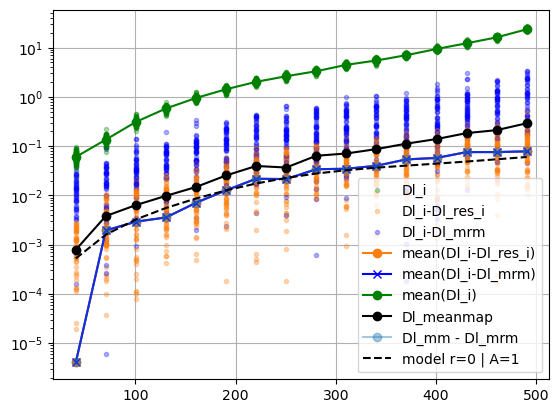

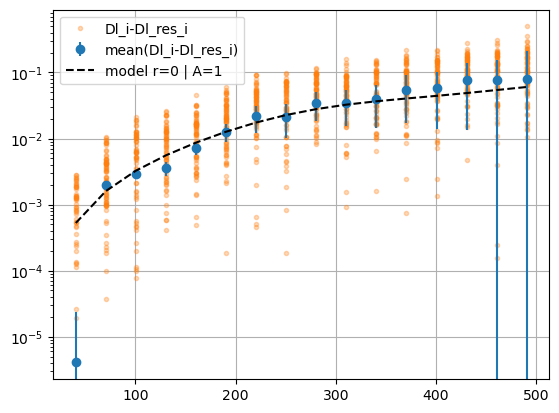

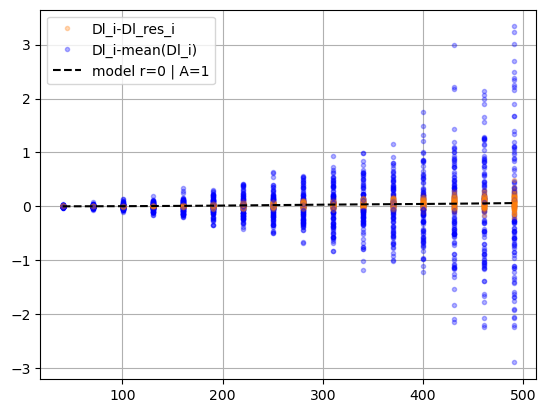

In [169]:
Alens = 2.5
r = 0.007

plt.figure()

for i in range(nreals):
    if i==0:
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-Dl_mrm')
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3)



plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4)
plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout


plt.figure()

for i in range(nreals):
    if i==0:
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)

plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),yerr = np.sqrt(len(data['DlBB_i'][:,0,0,0]))*np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0)**2,fmt='o',label='mean(Dl_i-Dl_res_i)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)



plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

plt.figure()

for i in range(nreals):
    if i==0:
        # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-mean(Dl_i)')
    # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3)



# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4)
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

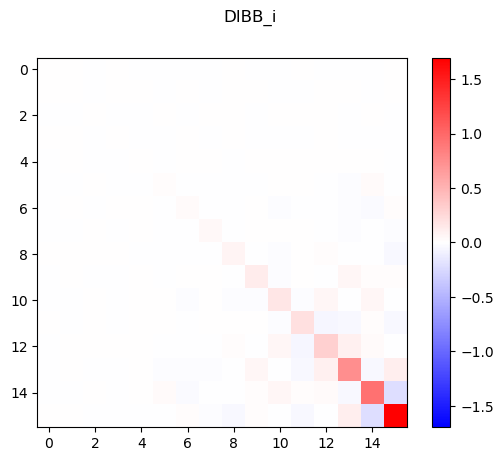

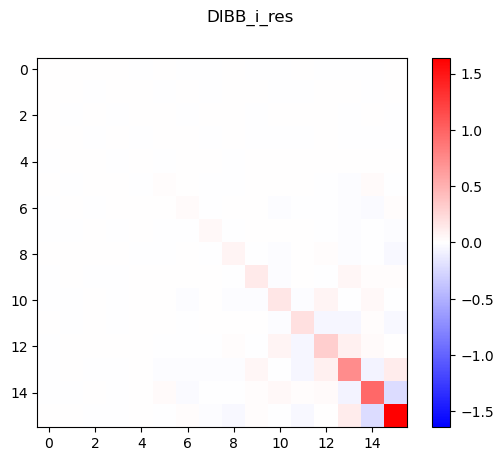

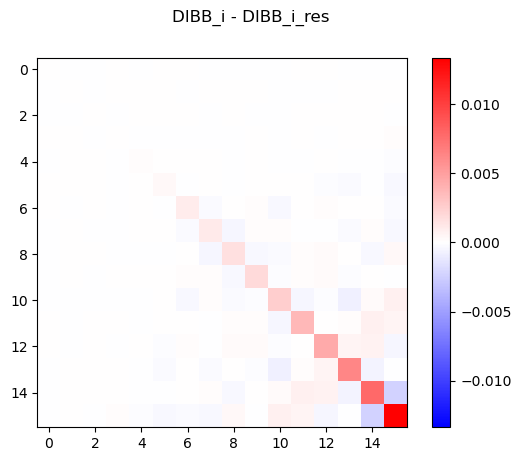

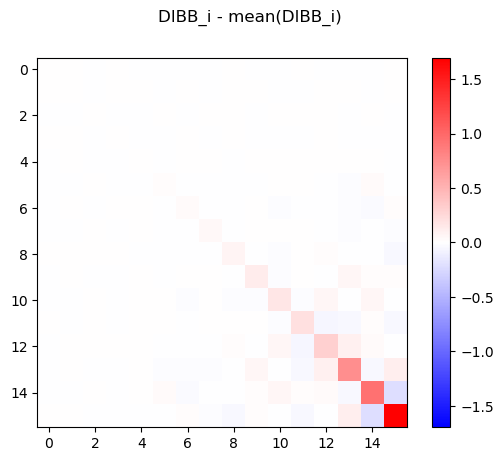

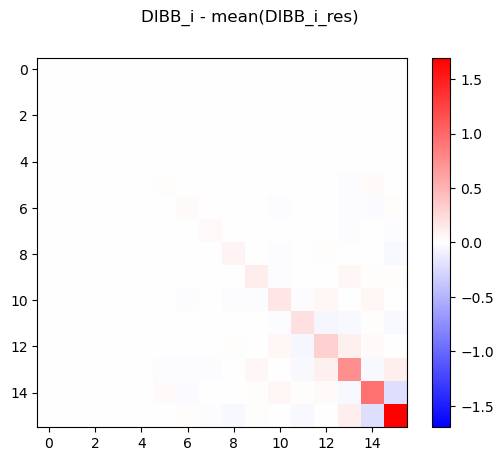

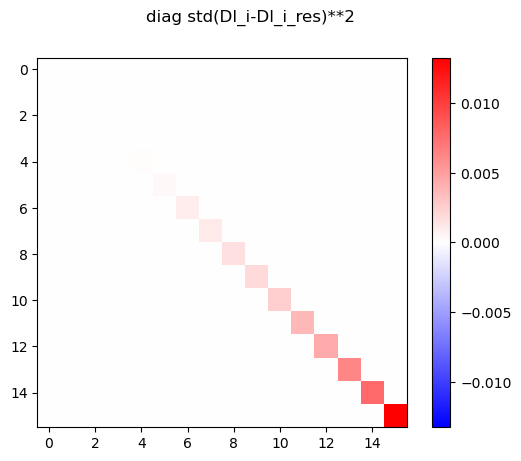

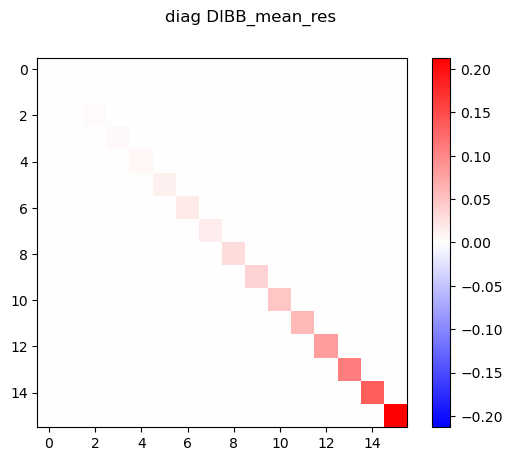

In [162]:
cov_cc_dli = np.cov( data['DlBB_i'][:, 0, 0,:], rowvar = False )
cov_cc = cov_cc_dli
plt.figure()
plt.suptitle('DlBB_i')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dlires = np.cov( data['DlBB_i_res'][:, 0, 0,:], rowvar = False )
cov_cc = cov_cc_dlires
plt.figure()
plt.suptitle('DlBB_i_res')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dli_dlires = np.cov( data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:], rowvar = False )
cov_cc = cov_cc_dli_dlires
plt.figure()
plt.suptitle('DlBB_i - DlBB_i_res')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dli_meandli = np.cov( data['DlBB_i'][:, 0, 0,:] - np.mean(data['DlBB_i'][:, 0, 0,:], axis = 0 ), rowvar = False)
cov_cc = cov_cc_dli_meandli
plt.figure()
plt.suptitle('DlBB_i - mean(DlBB_i)')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_dli_meandlires = np.cov( data['DlBB_i'][:, 0, 0,:] - np.mean(data['DlBB_i_res'][:, 0, 0,:], axis = 0 ), rowvar = False)
cov_cc = cov_cc_dli_meandlires
plt.figure()
plt.suptitle('DlBB_i - mean(DlBB_i_res)')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1, np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:], axis=0)**2)
cov_cc = cov_cc_diag_1
plt.figure()
plt.suptitle('diag std(Dl_i-Dl_i_res)**2')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov_cc_diag_2 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_2, data['DlBB_mean_res'][0,0,:])
cov_cc = cov_cc_diag_2
plt.figure()
plt.suptitle('diag DlBB_mean_res')
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [142]:
cov_cc = cov_cc_diag_1 #cov_cc_dli_dlires

cov_cc_inv = np.linalg.inv(cov_cc)

def foregrounds(ell, A, alpha):
    return A * (ell/80)**alpha
    
def log_prior(x):
    r, Alens = x
    if r > 1 or r < -1:
        return -np.inf

    if Alens < 0.1 or Alens > 4:
        return -np.inf

    # if alpha > 0 or alpha < -1:
    #    return -np.inf
    return 0

def like(x):

    r, Alens = x

    ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens)])#, foregrounds(data['ell'], A, alpha)])

    # yobs = np.array( data['DlBB_mean'][0,0,:] )
    yobs = np.array( data['DlBB_mean'][0,0,:] - data['DlBB_mean_res'][0,0,:])

    res = ymodel - yobs

    lp = log_prior(x)

    L_cmb_cmb = lp - 0.5 * ((res[0].T @ cov_cc_inv @ res[0]))
    
    #L_dust_cmb = lp - 0.5 * (res[1].T @ np.linalg.inv(cov_dc) @ res[1])
    #L_cmb_dust = lp - 0.5 * (res[0].T @ np.linalg.inv(cov_cd) @ res[0])
    #L_dust_dust = lp - 0.5 * (res[1].T @ np.linalg.inv(cov_dd) @ res[1])

    L = L_cmb_cmb # + L_dust_dust + L_dust_cmb + L_cmb_dust
    
    return L

In [143]:
import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

nwalkers = 30

In [144]:
x0 = np.zeros((nwalkers, 2))

x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
#x0[:, 2] = np.random.normal(-0.1, 0.001, (nwalkers))
#x0[:, 3] = np.random.normal(-0.1, 0.001, (nwalkers))
#x0[:, 2] = np.random.normal(-0.5, 0.001, (nwalkers))

In [145]:
from multiprocess import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, x0.shape[1], like, pool=pool)
    sampler.run_mcmc(x0, 3000)#, progress=True)

In [146]:
chainflat = sampler.get_chain(discard=300, thin=15, flat=True)
chains = sampler.get_chain()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

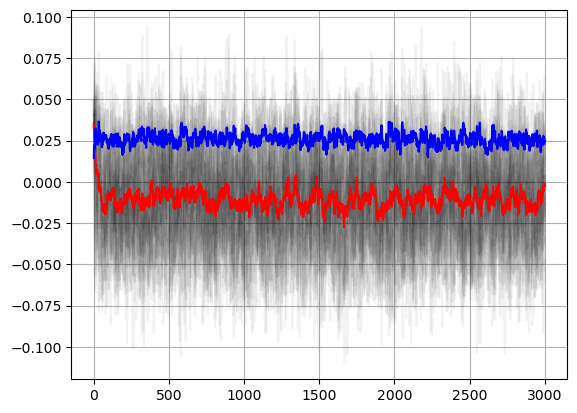

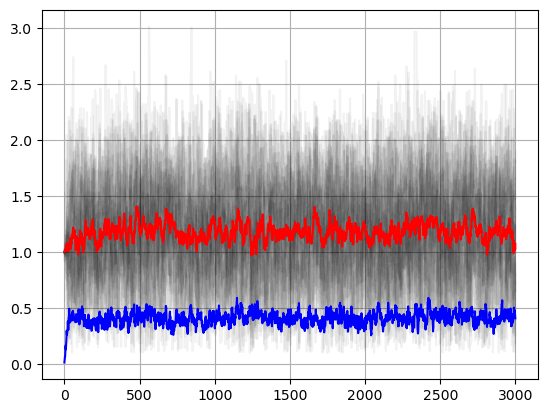

In [147]:
plt.figure()

for i in range(nwalkers):
    plt.plot(chains[:, i, 0], '-k', alpha=0.05)
plt.plot(np.mean(chains, axis=1)[:, 0], '-r')
plt.plot(np.std(chains, axis=1)[:, 0], '-b')
# plt.axhline(0, ls='--', color='black')
# plt.axhline(0.015, ls='--', color='green')
# plt.xlim(0, chains.shape[0])
# plt.ylim(-0.05, 0.1)
plt.grid()
plt.tight_layout


plt.figure()

for i in range(nwalkers):
    plt.plot(chains[:, i, 1], '-k', alpha=0.05)
plt.plot(np.mean(chains, axis=1)[:, 1], '-r')
plt.plot(np.std(chains, axis=1)[:, 1], '-b')
# plt.axhline(0, ls='--', color='black')
# plt.axhline(0.015, ls='--', color='green')
# plt.xlim(0, chains.shape[0])
# plt.ylim(-0.05, 0.1)
plt.grid()
plt.tight_layout

Removed no burn in


<Figure size 1200x800 with 0 Axes>

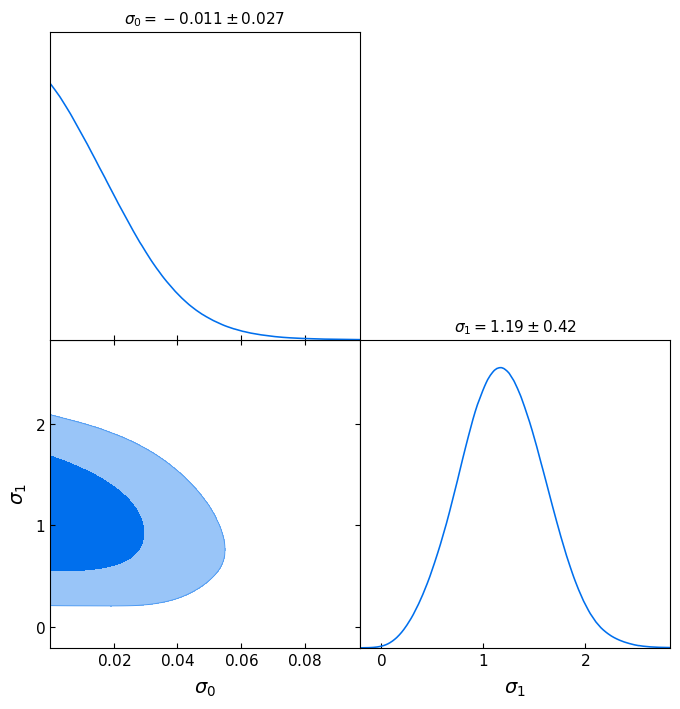

In [148]:
labels = []
names = []

for i in range(chains.shape[2]):
    names += [f'sig_{i}']
    labels += [f'\sigma_{i}']
            
s = MCSamples(samples=chainflat, names=names, labels=labels, label=r'', ranges={'sig_0':(0, None)})

plt.figure(figsize=(12, 8))

# Triangle plot
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([s], filled=True, title_limit=1)
plt.savefig('d0 - diagonal cov corrected')
plt.show()